<a href="https://colab.research.google.com/github/JonathanMairena/Otoscope-Automation-and-Enhancement/blob/main/otoai_classifier_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load and pre-process data 

In [ ]:
##access images in drive 
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Senior\ Design/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Senior Design


In [ ]:
##split images into training and validation sets 
import shutil 
import os 
import math 
import random

#define proportions 
train_prop = 0.7 
valid_prop = 0.3 

#define variables 
category_list = ['Normal','Abnormal']
src_dir = '/content/drive/My Drive/Senior Design/database/'
dest_dir = '/content/drive/My Drive/Senior Design/database_custom_split/'

for cat in category_list:
  #path names
  src_path = src_dir + cat
  dest_dir1 = dest_dir+'train/'+cat
  dest_dir2 = dest_dir+'validation/'+cat

  #file names 
  os.chdir(src_path)
  files = [f for f in os.listdir() if os.path.isfile(f)]
  random.shuffle(files)

  #get training and validation file coutns 
  train_count = math.ceil(train_prop*len(files))
  valid_count = len(files)-train_count 

  #get files to segregate train and validation
  train_data_list = files[0:train_count]
  valid_data_list = files[train_count+1:]

  #copy files from source to destination 
  for train_data in train_data_list: 
    train_path = src_path+'/'+train_data
    shutil.copy(train_path,dest_dir1)
  
  for valid_data in valid_data_list: 
    valid_path = src_path+'/'+valid_data
    shutil.copy(valid_path,dest_dir2)
    

In [ ]:
##assign directories for training and validation 
import os

base_dir = '/content/drive/My Drive/Senior Design/database_custom_split/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training abnormal pictures
train_abnormal_dir = os.path.join(train_dir, 'Abnormal')

# Directory with our training normal pictures
train_normal_dir = os.path.join(train_dir, 'Normal')

# Directory with our validation abnormal pictures
validation_abnormal_dir = os.path.join(validation_dir, 'Abnormal')

# Directory with our validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'Normal')

# Check number of training and test images 
print('total training abnormal images:', len(os.listdir(train_abnormal_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total validation abnormal images:', len(os.listdir(validation_abnormal_dir)))
print('total validation normal images:', len(os.listdir(validation_normal_dir)))

total training abnormal images: 847
total training normal images: 637
total validation abnormal images: 361
total validation normal images: 271


In [ ]:
##data augmentation, flow train + validation images 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=30,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary')


Found 1484 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


#Small ConvNet

In [ ]:
##design network

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):
  # Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
  # the three color channels: R, G, and B
  img_input = layers.Input(shape=(150, 150, 3))

  # First convolution extracts 16 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(16, 3, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)

  # Second convolution extracts 32 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)

  # Third convolution extracts 64 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Convolution2D(64, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)

  # Flatten feature map to a 1-dim tensor
  x = layers.Flatten()(x)

  # Create a fully connected layer with ReLU activation and 512 hidden units
  x = layers.Dense(512, activation='relu')(x)

  # Add a dropout rate of 0.5
  x = layers.Dropout(0.5)(x)

  # Create output layer with a single node and sigmoid activation
  output = layers.Dense(1, activation='sigmoid')(x)

  # Configure and compile the model
  model = Model(img_input, output)
  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.001),
                metrics=['acc'])
  

In [ ]:
##train network
with tf.device('/device:GPU:0'):  
  history = model.fit_generator(
        train_generator,
        steps_per_epoch=49,
        epochs=125,
        validation_data=validation_generator,
        validation_steps=21,
        verbose=2)
  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/125
49/49 - 25s - loss: 0.7740 - acc: 0.5750 - val_loss: 0.6063 - val_acc: 0.6635
Epoch 2/125
49/49 - 22s - loss: 0.6303 - acc: 0.6362 - val_loss: 0.5529 - val_acc: 0.7063
Epoch 3/125
49/49 - 22s - loss: 0.6060 - acc: 0.6713 - val_loss: 0.5716 - val_acc: 0.7238
Epoch 4/125
49/49 - 22s - loss: 0.6235 - acc: 0.6719 - val_loss: 0.6076 - val_acc: 0.7000
Epoch 5/125
49/49 - 22s - loss: 0.6250 - acc: 0.6637 - val_loss: 0.6566 - val_acc: 0.6571
Epoch 6/125
49/49 - 22s - loss: 0.6365 - acc: 0.6465 - val_loss: 0.6459 - val_acc: 0.6571
Epoch 7/125
49/49 - 22s - loss: 0.6241 - acc: 0.6568 - val_loss: 0.5838 - val_acc: 0.6825
Epoch 8/125
49/49 - 22s - loss: 0.6001 - acc: 0.6465 - val_loss: 0.5290 - val_acc: 0.7222
Epoch 9/125
49/49 - 22s - loss: 0.5652 - acc: 0.6850 - val_loss: 0.5046 - val_acc: 0.7206
Epoch 10/125
49/49 - 22s - loss: 0.5789 - acc: 0.6781 - val_loss: 0.5082 - val_acc: 0.7444
Epoch 11/125
49/49 - 22s - loss: 0.5711 - acc: 0.6781 - val_loss: 0.5137 - val_acc: 0.7524
Epoch 12

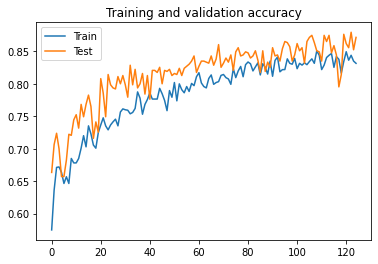

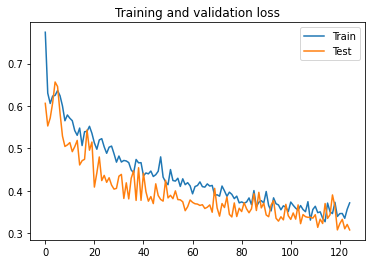

In [ ]:
##Visualize loss and accuracy curves 

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Train')
plt.plot(epochs, val_acc, label='Test')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss,label='Test')
plt.title('Training and validation loss')
plt.legend()